In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib import cm
from qutip import *
from qutip.ipynbtools import plot_animation
from matplotlib import animation
from IPython.display import HTML
from wigner_animation import wigner_animate

In [2]:
def plot_expection(new, tlist, operator, operator2 = None, operator3 = None):
    fig, ax = plt.subplots(figsize=(12,6))
    expectation = [np.trace(new.states[i]*operator) for i in range(len(tlist))]
    ax.plot(tlist, np.real(expectation), 'r')
    if operator2 is not None:
        expectation2 = [np.trace(new.states[i]*operator2) for i in range(len(tlist))]
        ax.plot(tlist, np.real(expectation2), 'b')
    if operator3 is not None:
        expectation3 = [np.trace(new.states[i]*operator3) for i in range(len(tlist))]
        ax.plot(tlist, np.real(expectation3), 'g')
    ax.legend(("123"))
    ax.set_xlabel('Time')
    ax.set_ylabel('expectation value');

In [3]:
def energy_plot(energies):
    x = np.arange(len(energies))
    fig, ax = plt.subplots()
    ax.scatter(x, energies, s=1444, marker="_", linewidth=3, zorder=3)
    ax.grid(axis='y')

In [28]:
N = 10 # number of levels in Hilbert space
N_q = 3 #g,e,f not h
GRID_SIZE = 6
x_e = 2*np.pi* -50e3
x_f = 2*np.pi* -100e3
x_ab = 2*np.pi* -0.4e3 #Cavity a-b Cross-Kerr
w_e = 2*np.pi* 6.5e9 #Transmon frequency
K = 2*np.pi* -7 #Cavity self-Kerr
d = 2*np.pi* -200e6 #Transmon unharmonicity


g2 = 2*np.pi * 0.5e6 #drive strength phi_a*phi_q*xi
g3 = 2*np.pi * 0.8e6 #drive strength phi_b*phi_q*xi
omega_CROT = 2*np.pi * 1e6 #drive strength phi_a*phi_b*phi_q*xi (not squered)
delta = 2*np.pi * 50e6
delta2 = 2*np.pi * 10e6 #delta for the a-q drive
delta3 = 2*np.pi * 10e6 #delta for the b-q drive

kappa = 0 #1/1e-3 # Cavity decay rate

alpha = 2.0


In [29]:
vac = basis(N,0)
rho_vac = vac*vac.dag()

qubit = fock_dm(N_q,0)
cat_a = (coherent(N,alpha) - coherent(N,-alpha)) + (coherent(N,alpha) + coherent(N,-alpha))
cat_b = coherent(N,alpha) - coherent(N,-alpha)

rho_cat_a = ket2dm(cat_a)
rho_cat_b = cat_b * cat_b.dag()

g_g = fock_dm(N_q,0) # |g><g|
e_e = fock_dm(N_q,1) # |e><e|
f_f = fock_dm(N_q,2) # |f><f|
#h_h = fock_dm(N_q,3) # |h><h|



# SYSTEM IS (QUBIT, CAVITY_A, CAVITY_B)

H_0 = (0
       + w_e* 0 * tensor(e_e, qeye(N), qeye(N)) #Transmon frequency
       + d * tensor(f_f, qeye(N), qeye(N)) #Transmon unharmonicity
       #+ K * tensor(qeye(N_q), (destroy(N).dag())**2 * (destroy(N))**2, qeye(N)) #Cavity_a self-Kerr
       #+ K * tensor(qeye(N_q), qeye(N), (destroy(N).dag())**2 * (destroy(N))**2) #Cavity_b self-Kerr
       
       + x_e * tensor(e_e, num(N), qeye(N)) #Transmon-Cavity_a Cross-Kerr
       + x_e * tensor(e_e,  qeye(N),num(N)) #Transmon-Cavity_b Cross-Kerr
       
       + x_f * tensor(f_f, num(N), qeye(N)) #Transmon-Cavity_a Cross-Kerr
       + x_f * tensor(f_f,  qeye(N),num(N)) #Transmon-Cavity_b Cross-Kerr
       #+ x_ab * tensor(qeye(N_q), num(N), num(N)) #Cavity_a_b Cross-Kerr
    )




a_b_qd = tensor(destroy(N_q).dag(), destroy(N), destroy(N))
a_qd = tensor(destroy(N_q).dag(), destroy(N), qeye(N))
qd = tensor(destroy(N_q).dag(), qeye(N), qeye(N))
b_qd = tensor(destroy(N_q).dag(), qeye(N), destroy(N))

H1 = [a_b_qd, 'g*exp(1j*(Delta)*t) * (t<t_pulse)']
H2 = [a_b_qd.dag(), 'g*exp(-1j*(Delta)*t) * (t<t_pulse)']

H3 = [a_qd,       'g2*exp(1j*(Delta2+unhar)*t)']
H4 = [a_qd.dag(), 'g2*exp(-1j*(Delta2+unhar)*t)']

H5 = [b_qd,       'g3*exp(1j*(Delta3+unhar)*t)']
H6 = [b_qd.dag(), 'g3*exp(-1j*(Delta3+unhar)*t)']


H = [H_0,H1,H2,H3,H4,H5, H6] #] ,


system = tensor(qubit, rho_cat_a, rho_cat_b).unit()

In [30]:
c_ops = []  # Build collapse operators

c_ops.append(np.sqrt(kappa) * tensor(qeye(N_q), destroy(N), qeye(N))) #cavity_a decay
c_ops.append(np.sqrt(kappa) * tensor(qeye(N_q), qeye(N), destroy(N))) #cavity_b decay


In [31]:
a_rot = 1
b_rot = 1
CROT_time = np.pi / (a_rot * b_rot) * (delta / omega_CROT**2)
time_steps = 10000
simulation_time = CROT_time
delta2 = 2 * g2**2 / x_e
delta3 = 2*g3**2 / x_e

args = {
    'g': omega_CROT,
    'g2': g2,
    'g3': g3,
    'Delta': delta,
    't_pulse': 1*CROT_time,
    'unhar': -d,
    'Delta2': delta2,
    'Delta3': delta3,
    't_pulse2': CROT_time/40
}

print("Gate time is: ", args['t_pulse'])
print("g is:", args['g'])
print("Delta is:", args['Delta'])
print("Delta/g is (should be large):", args['Delta']/args['g'])
print("simulation dt is:", simulation_time/time_steps)
print("delta2 is:", delta2)
print("g2 is:", g2)
print("Delta2/g2 is (should be large):", args['Delta2']/args['g2'])
print("delta3 is:", delta3)
print("g3 is:", g3)
print("Delta3/g3 is (should be large):", args['Delta3']/args['g3'])


tlist = np.linspace(0, simulation_time, time_steps)



e_ops = []# [tensor(num(N_q), qeye(N), qeye(N))]
options = Options(rhs_reuse=False,store_final_state=True)
print('d')
#new = mesolve(H, system, tlist, c_ops, progress_bar=True)
new = mesolve(H, system, tlist, c_ops, e_ops, args = args, options=options, progress_bar=True)

Gate time is:  2.4999999999999998e-05
g is: 6283185.307179586
Delta is: 314159265.3589793
Delta/g is (should be large): 50.0
simulation dt is: 2.4999999999999996e-09
delta2 is: -62831853.071795866
g2 is: 3141592.653589793
Delta2/g2 is (should be large): -20.000000000000004
delta3 is: -160849543.8637974
g3 is: 5026548.245743669
Delta3/g3 is (should be large): -32.0
d
10.0%. Run time: 212.82s. Est. time left: 00:00:31:55
20.0%. Run time: 429.06s. Est. time left: 00:00:28:36
30.0%. Run time: 641.07s. Est. time left: 00:00:24:55
40.0%. Run time: 850.70s. Est. time left: 00:00:21:16
50.0%. Run time: 1124.33s. Est. time left: 00:00:18:44
60.0%. Run time: 1424.44s. Est. time left: 00:00:15:49
70.0%. Run time: 1730.63s. Est. time left: 00:00:12:21
80.0%. Run time: 2040.78s. Est. time left: 00:00:08:30
90.0%. Run time: 2344.40s. Est. time left: 00:00:04:20
Total run time: 2644.33s


In [8]:
#qsave(new, 'n=14,d=125M,d2=-90M,d3=-251M')

In [35]:
rho_cavity_final = ptrace(new.final_state, 1)
rho_cavity_start = ptrace(new.states[0], 1)
rho_cavity_final_b = ptrace(new.final_state, 2)


(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

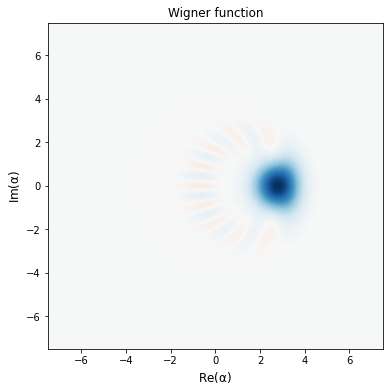

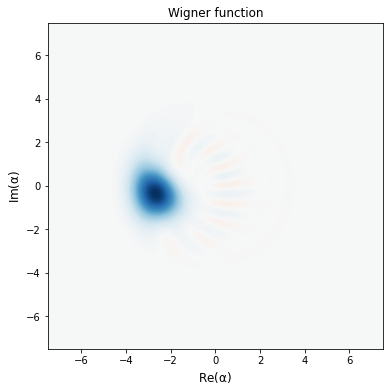

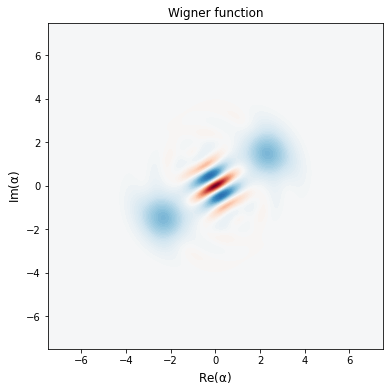

In [36]:
plot_wigner(rho_cavity_start)
plot_wigner(rho_cavity_final)
plot_wigner(rho_cavity_final_b)

C:\Users\rosengrp\anaconda3\lib\site-packages\matplotlib\animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


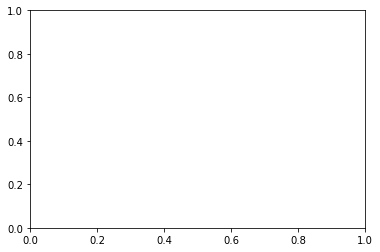

In [42]:
ani = wigner_animate(new, trace_dimension=1 , skip_frames = int(np.floor(time_steps/100)), tlist=tlist)

In [43]:
HTML(ani.to_html5_video())

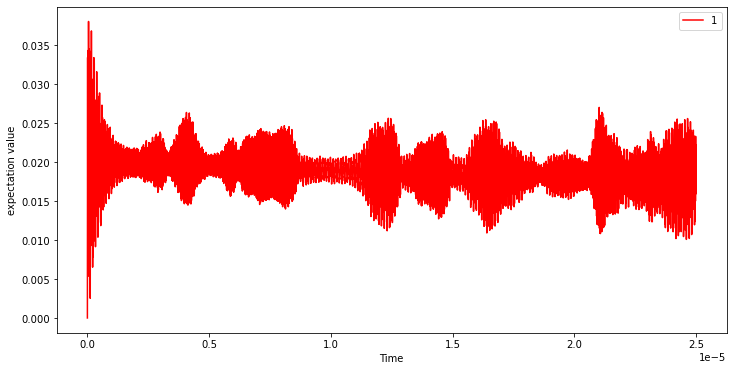

In [13]:
n_q_tensor = tensor(num(N_q), qeye(N), qeye(N))
plot_expection(new,tlist, n_q_tensor)

In [37]:
print(fidelity(new.final_state, system))
for i in range(10):
    for j in range(10):
        print("i=", i)
        print("j=", j)
        print(fidelity(new.final_state, tensor(qubit, ket2dm(coherent(N,-alpha*np.exp(0.1j*i))), ket2dm(coherent(N,alpha*np.exp(0.1j*j)) - coherent(N,-alpha*np.exp(0.1j*j)))).unit()))

0.02985591821543439
i= 0
j= 0
0.5087036375568369
i= 0
j= 1
0.6196882180497906
i= 0
j= 2
0.7258753508987147
i= 0
j= 3
0.8168639348081407
i= 0
j= 4
0.8831246076720333
i= 0
j= 5
0.9173872955861961
i= 0
j= 6
0.9157016682397952
i= 0
j= 7
0.8780264061997812
i= 0
j= 8
0.8082840546081308
i= 0
j= 9
0.713851731794445
i= 1
j= 0
0.525839383591814
i= 1
j= 1
0.635904370127337
i= 1
j= 2
0.7421258393723542
i= 1
j= 3
0.83418867183572
i= 1
j= 4
0.9024249181148446
i= 1
j= 5
0.9392637981254169
i= 1
j= 6
0.9403538311330263
i= 1
j= 7
0.9052182775603979
i= 1
j= 8
0.8373690303023433
i= 1
j= 9
0.7438558594324028
i= 2
j= 0
0.5203765235130996
i= 2
j= 1
0.6261821755283793
i= 2
j= 2
0.7294751143909869
i= 2
j= 3
0.8203396611563489
i= 2
j= 4
0.8892369808652202
i= 2
j= 5
0.9284621132061612
i= 2
j= 6
0.9333100865516236
i= 2
j= 7
0.9027913202060129
i= 2
j= 8
0.8398103877924581
i= 2
j= 9
0.7507940344450498
i= 3
j= 0
0.49348027507675
i= 3
j= 1
0.5920588582107628
i= 3
j= 2
0.6896505803321334
i= 3
j= 3
0.7770426862567914
i

In [38]:
for i in range(10):
    print(fidelity(system, tensor(qubit, ket2dm(coherent(N,alpha*np.exp(0.1j*i))), rho_cat_b).unit()))

0.9999998319525496
0.9808351821517808
0.9253262225341551
0.8393394819727695
0.7316954515281111
0.6129794580667519
0.49404962326622537
0.3845340420790404
0.29138542794418965
0.2176473072833938


In [16]:
#ani.save('1,+,3_drives_a=1.mp4')

In [17]:
#ani.save('0,+,3_drives_a=1.gif', writer="ImageMagickWriter")

In [39]:
for i in range(10):
    print(fidelity(rho_cavity_final, ket2dm(coherent(N,-alpha*np.exp(0.1j*i))).unit()))

0.9252304528460885
0.949619266607731
0.942925889019262
0.9056006707248972
0.8411460027675385
0.7556379299563839
0.6568805198729102
0.5533146627637137
0.4528354568396806
0.3616902129742393


In [40]:
for i in range(10):
    print(fidelity(rho_cavity_final_b, ket2dm(coherent(N,alpha*np.exp(0.1j*i)) - coherent(N,-alpha*np.exp(0.1j*i))).unit()))

0.5516795763696821
0.6543455427022745
0.7545261523040087
0.8425926944605989
0.9091448784431432
0.9465049831627117
0.9499056847350631
0.9182305410177909
0.8542215097002933
0.7641350263908036


In [26]:
print(fidelity(ptrace(new.final_state, 0),qubit))

0.9903828936712452


In [18]:
np.trace(new.final_state*tensor(num(N_q), qeye(N), qeye(N)))

(0.021243366850579197+0j)

In [19]:
g_g_tensor = tensor(g_g, qeye(N), qeye(N))
e_e_tensor = tensor(e_e, qeye(N), qeye(N))
f_f_tensor = tensor(f_f, qeye(N), qeye(N))
#plot_expection(new,tlist, g_g_tensor, e_e_tensor, f_f_tensor)

In [21]:
no_CROT=new

In [27]:
CROT_old=new